In [ ]:
pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-zxl6n3w5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-zxl6n3w5
  Resolved https://github.com/huggingface/transformers to commit a470f213961f9ef39e70bb9b6fd91817f096a2b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.8 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.57.0.dev0-py3-none-any.whl size=12598512 sha256=7ca923b42c234b7331a7e0b10144649a33bf160ae34488c0f4db7ba1325cd191
  Stored in directory: /tmp/pip-ephem-wheel-cache-6762fhv_/wheels/49/a7/50/c9fdabbf10e51bb1256adb0c1a587fedd7184f5bad28d47fe3
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import ast
import os
from PIL import Image
import torch
import cv2


## Config model

In [ ]:
from transformers import Sam2Processor, Sam2Model
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam2Model.from_pretrained("facebook/sam2-hiera-base-plus").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2-hiera-base-plus")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

## Fonctions

In [ ]:
def get_masks(image, bboxes, save_dir=None, base_name=None):
  inputs = processor(images=image, input_boxes=bboxes, return_tensors="pt").to(device)

  with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
  masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"])[0]

  return masks


In [ ]:
# source = https://stackoverflow.com/questions/76870102/how-to-save-segmented-images-or-masks-using-segment-anything-model-sam
def save_mask(mask, output_path):
    mask = mask.squeeze().cpu().numpy()
    mask_image = (mask * 255).astype(np.uint8)
    cv2.imwrite(output_path, mask_image)

In [ ]:
# source = https://stackoverflow.com/questions/76870102/how-to-save-segmented-images-or-masks-using-segment-anything-model-sam


def overlay_mask(mask, pil_image, output_path=None, color=(30, 144, 255), alpha=0.4, show=False):

    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy()

    image = np.array(pil_image)

    m = mask > 0.5

    color_mask = np.zeros_like(image)
    color_mask[m] = color

    overlay = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)

    overlay_pil = Image.fromarray(overlay.astype(np.uint8))

    if output_path is not None:
        overlay_pil.save(output_path)

    if show:
        plt.imshow(overlay_pil)
        plt.axis("off")
        plt.show()

    return overlay_pil

In [ ]:


def save_masks_df(df, img_input_dir, output_dir, bbox_list = False ):

    os.makedirs(output_dir, exist_ok=True)

    for idx, row in tqdm(df.iterrows()):
        img_path = os.path.join(img_input_dir, row['image_file'])
        if not os.path.isfile(img_path):
            print(f"Ce chemin n'existe pas: {img_path}")
            continue

        pil_img = Image.open(img_path).convert("RGB")

        if bbox_list : #bool pour récupérer directement liste bbox (uniquement pour résultats yolo)
            bbox = [ast.literal_eval(df.loc[idx,'bbox_list'])]
        else:
          bbox = [[row['x_min'], row['y_min'], row['x_max'], row['y_max']]]

        masks = get_masks(pil_img, [bbox])

        base_name = os.path.splitext(row['image_file'])[0]
        mask_path = os.path.join(output_dir, f"{row['detection_id']}.png")

        save_mask(masks, mask_path)

In [ ]:

def crop_and_save(image_path, bbox, output_path, padding_ratio=0.05):
    image = Image.open(image_path)
    width, height = image.size

    x_min, y_min, x_max, y_max = bbox

    # compute padding in both directions
    pad_x = int((x_max - x_min) * padding_ratio)
    pad_y = int((y_max - y_min) * padding_ratio)

    # expand bbox with padding, clamped to image size
    x_min = max(0, x_min - pad_x)
    y_min = max(0, y_min - pad_y)
    x_max = min(width,  x_max + pad_x)
    y_max = min(height, y_max + pad_y)

    cropped = image.crop((x_min, y_min, x_max, y_max))
    cropped.save(output_path)

In [ ]:
def mask_crops_df(df, masks_dir, output_dir, bbox_list=False) :
    os.makedirs(output_dir, exist_ok=True)
    for idx, row in tqdm(df.iterrows()):
      mask_id = row['detection_id']
      mask_path = os.path.join(masks_dir, f"{mask_id}.png")

      if bbox_list : #bool pour récupérer directement liste bbox (uniquement pour résultats yolo)
          bbox = [ast.literal_eval(df.loc[idx,'bbox_list'])]
      else:
          bbox = [[row['x_min'], row['y_min'], row['x_max'], row['y_max']]]

      crop_and_save(mask_path, bbox[0], os.path.join(output_dir, f"{mask_id}.png"), padding_ratio=0.1)

## Corpus objets

In [ ]:
#src = str(Path.cwd().resolve().parents[0]/ 'src')
#sys.path.append(src)
#from config.paths import ROOT, DATA, EXPERIMENTS, DOC_IMGS, CLEANED, PROCESSED, METADATA

In [ ]:
EXPERIMENTS = '/content/drive/MyDrive/dataHN/experiments'
DATA = '/content/drive/MyDrive/dataHN/data'
METADATA = '/content/drive/MyDrive/dataHN/metadata'

det_csv_path = os.path.join(DATA, 'processed', 'crops_csv', 'dino_obj_detections.csv')
dir_img = os.path.join(DATA, 'cleaned', 'obj_imgs_cleaned')
experiment_dir = os.path.join(EXPERIMENTS, "sam2_obj_segment")
masks_dir = os.path.join(DATA, "segmented", "sam2_masks", "masks_objets")
crops_dir = os.path.join(DATA, "segmented", "sam2_masks_crops", "masks_objets_crops")
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(crops_dir, exist_ok=True)

In [ ]:
df_objets = pd.read_csv(det_csv_path, encoding='UTF-8')

In [ ]:
df_objets.head(1)

,image_file,label,score,x_min,y_min,x_max,y_max,bbox_id,detection_id,bbox_list
0,Christies_2005-04-21_697_01.jpg,object,0.808,32.31,30.89,489.67,486.41,1,Christies_2005-04-21_697_01_01,"[32.31, 30.89, 489.67, 486.41]"


### Test

In [ ]:
test_file = 'Sothebys_2024-04-24_211_01.jpg'

In [ ]:
image_path = f"{dir_img}/{test_file}"
image = Image.open(image_path)

df_img = df_objets[df_objets['image_file'] == test_file]
bbox = df_img[['x_min', 'y_min', 'x_max', 'y_max']].values.tolist()


In [ ]:
masks =  get_masks(image, [bbox])


In [ ]:
masks.shape

torch.Size([1, 1, 4096, 4096])

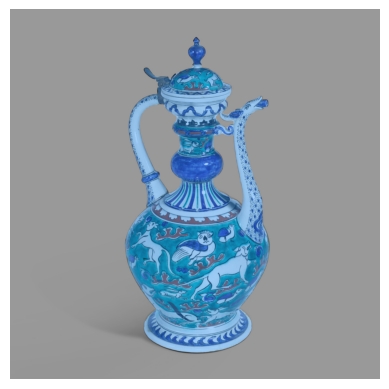

In [ ]:
mask_overlay = overlay_mask(masks, image, output_path=None, color=[30, 144, 255], alpha=0.4, show=True)


In [ ]:
save_mask(masks, 'test.png')
os.path.isfile('test.png')

True

In [ ]:
df_test = df_objets.iloc[:10].copy()

In [ ]:
save_masks_df(df_test, dir_img, '/content/test_results/')

10it [02:58, 17.85s/it]


### Prédictions SAM2 masks sur corpus objets

In [ ]:
len(df_objets)

2127

In [ ]:
save_masks_df(df_objets, dir_img, masks_dir)

2127it [44:37,  1.26s/it]


### Crops masks

In [ ]:
mask_crops_df(df_objets, masks_dir, crops_dir, bbox_list=False)

2127it [23:14,  1.53it/s]


## Corpus documents

In [ ]:
EXPERIMENTS = '/content/drive/MyDrive/dataHN/experiments'
DATA = '/content/drive/MyDrive/dataHN/data'
METADATA = '/content/drive/MyDrive/dataHN/metadata'

/Users/enki/data/Git/Memoire-M2HN/experiments/yolo_doc_ill_detect/predicts/csv/run8_yolo11m_prediction_results.csv

det_csv_path = os.path.join(DATA, 'processed', 'crops_csv', 'yolo_ill_detections.csv')
dir_img = os.path.join(DATA, 'cleaned', 'doc_imgs_cleaned')
experiment_dir = os.path.join(EXPERIMENTS, "sam2_ill_segment")
masks_dir = os.path.join(DATA, 'segmented', "sam2_masks", "masks_docs")
crops_dir = os.path.join(DATA, 'segmented', "sam2_masks_crops", "masks_docs_crops")
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(crops_dir, exist_ok=True)

In [ ]:
df_docs = pd.read_csv(det_csv_path, encoding='UTF-8')

In [ ]:
df_docs.head(1)

,image_file,class_id,class_name,score,x1,y1,x2,y2,bbox_index,bbox_id,detection_id,bbox_list
0,Beaumont-Collinot_1859_145.jpg,0,illustration,0.904017,549.692993,618.003601,2219.839355,3050.201172,0,1,Beaumont-Collinot_1859_145_01,"[549.6929931640625, 618.0036010742188, 2219.83..."


### Test

In [ ]:
test_file = 'APT_1869_0040.jpg'

In [ ]:
image_path = f"{dir_img}/{test_file}"
image = Image.open(image_path)

df_img = df_docs[df_docs['image_file'] == test_file].copy()
df_img.reset_index(drop=True, inplace=True)
bbox = ast.literal_eval(df_img.loc[3,'bbox_list'])

In [ ]:
masks =  get_masks(image, [[bbox]])


In [ ]:
masks.shape

torch.Size([1, 1, 3485, 2254])

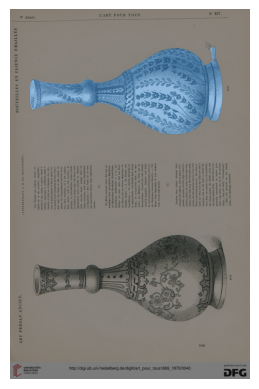

In [ ]:
mask_overlay = overlay_mask(masks, image, output_path=None, color=[30, 144, 255], alpha=0.4, show=True)


In [ ]:
save_mask(masks, 'test.png')
os.path.isfile('test.png')

True

In [ ]:
df_test = df_docs.iloc[:10].copy()

In [ ]:
save_masks_df(df_test, dir_img, '/content/test_doc_results/', bbox_list = True)

10it [00:12,  1.22s/it]


### Prédictions SAM2 masks sur corpus docs

In [ ]:
print(len(df_docs))

7705


In [ ]:
save_masks_df(df_docs, dir_img, masks_dir, bbox_list=True)

1729it [43:52,  1.09s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131396860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
3933it [1:36:02,  1.10s/it]

In [ ]:
#suite
list_segmented= [file.split('.')[0] for file in os.listdir(masks_dir)]
df_docs_restant = df_docs[~df_docs['detection_id'].isin(list_segmented)]
print(f'images ségmentées : {len(list_segmented)}, images non ségmentées : {len(df_docs_restant)}, total : {len(list_segmented)+len(df_docs_restant)}')

images ségmentées : 3934, images non ségmentées : 3771, total : 7705


In [ ]:
save_masks_df(df_docs_restant, dir_img, masks_dir, bbox_list=True)

1823it [44:42,  1.28s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131542390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
3771it [1:32:12,  1.47s/it]


### Process crops

In [ ]:
mask_crops_df(df_docs, masks_dir, crops_dir, bbox_list=True)

1729it [22:55,  1.52it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131396860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
5757it [1:13:37,  1.08it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (131542390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
7705it [1:37:43,  1.31it/s]
